In this notebook we will follow the same approach as in LSTM_2, but this time adding more features to our feature set.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_ta as ta
import pandas_datareader.data as web

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.losses import MeanSquaredError

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [137]:
ticker = 'SPY'
start = '1993-01-01'
end = '2025-01-01'

In [130]:
df = yf.download(ticker, start=start, end=end)
df.columns = [price for price, _ in df.columns]
df['returns'] = df.Close.pct_change()
df = df.dropna()

C:\Users\Owen\AppData\Local\Temp\ipykernel_30156\857682478.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


# Some initial plots

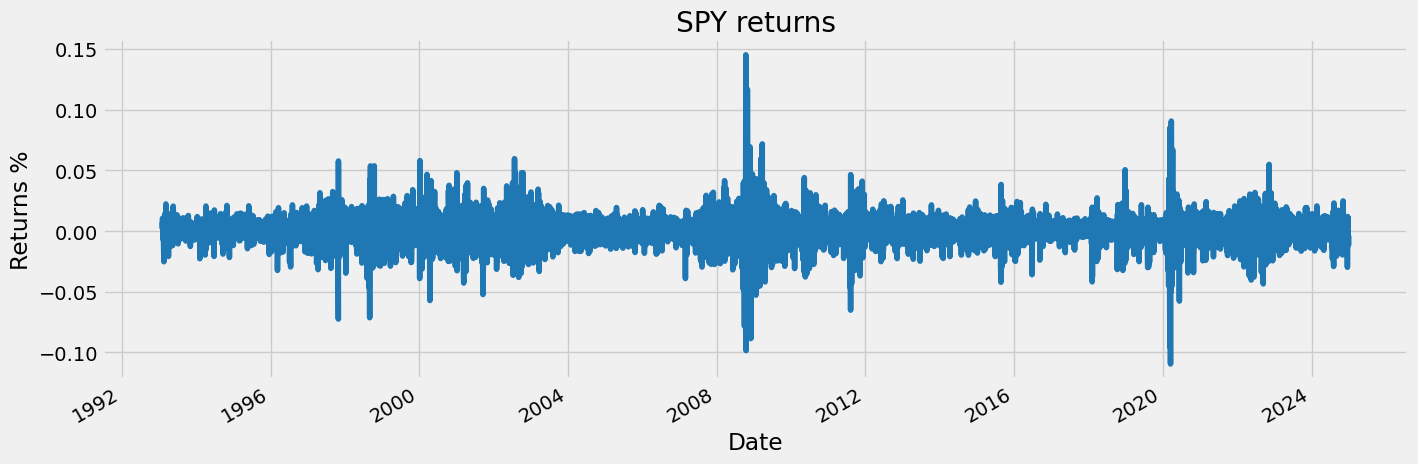

In [133]:
df.returns.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title=f'{ticker} returns', 
              ylabel='Returns %')
plt.show()

# Feature creation

In [9]:
# Calendar features
df['quarter'] = df.index.quarter

# Overlap features
df['ema_div'] = ta.ema(close=df.Close, length=5) - ta.ema(close=df.Close, length=20) 

# Momentum features
df['rsi'] = ta.rsi(close=df.Close)

# Trend features
df['chop'] = ta.chop(high=df.High, low=df.Low, close=df.Close)

#Volume features
df['obv'] = ta.obv(close=df.Close, volume=df.Volume)

In [10]:
VIX_data = yf.download('^VIX', start=start, end=end)
VIX_data.columns = [price for price, _ in VIX_data.columns]
df['VIX_ma'] = VIX_data.Close.rolling(window=5).mean()

C:\Users\Owen\AppData\Local\Temp\ipykernel_30156\2757970680.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX_data = yf.download('^VIX', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [11]:
treasury_yields = web.DataReader(["DGS10","DGS2"], "fred", start=start, end=end)
df['treasury_10y'] = treasury_yields.DGS10
df['treasury_2y'] = treasury_yields.DGS2
df['treasury_10y_2y_spread'] = treasury_yields.DGS10 - treasury_yields.DGS2

In [12]:
df.head()

,Close,High,Low,Open,Volume,returns,quarter,ema_div,rsi,chop,obv,VIX_ma,treasury_10y,treasury_2y,treasury_10y_2y_spread
Date,,,,,,,,,,,,,,,
1993-02-01,24.553860,24.553860,24.397797,24.397797,480500,0.007113,1,NaN,NaN,NaN,480500.0,12.050,6.38,4.19,2.19
1993-02-02,24.605858,24.623198,24.484476,24.536497,201300,0.002118,1,NaN,NaN,NaN,681800.0,12.210,6.46,4.25,2.21
1993-02-03,24.865965,24.883305,24.623201,24.640541,529400,0.010571,1,NaN,NaN,NaN,1211200.0,12.232,6.45,4.27,2.18
1993-02-04,24.969995,25.022016,24.675211,24.952655,531500,0.004184,1,NaN,NaN,NaN,1742700.0,12.282,6.39,4.19,2.20
1993-02-05,24.952673,25.004694,24.813951,24.952673,492100,-0.000694,1,NaN,NaN,NaN,1250600.0,12.378,6.32,4.07,2.25


In [13]:
df = df.dropna().copy()

# Train-test split

In [23]:
date_split = '2023-07-31'
index_split = df.index.get_loc(date_split)
lookback = 30

In [25]:
y_train = np.array(df.returns.loc[df.index<=date_split].copy())
y_test = np.array(df.returns.loc[df.index>date_split].copy())

train_features = df.drop(['returns','Close','High','Low','Open'], axis=1).loc[df.index <= date_split].copy()
test_features = df.drop(['returns','Close','High','Low','Open'], axis=1).loc[df.index > date_split].copy()

In [27]:
X_scaler = StandardScaler()
train_features = X_scaler.fit_transform(train_features)
test_features = X_scaler.transform(test_features)

In [29]:
y_train = y_train[lookback:].reshape(-1,1)
y_test = y_test[lookback:].reshape(-1,1)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

print(y_train.shape)
print(y_test.shape)

(7570, 1)
(325, 1)


In [31]:
X_train = [[] for _ in range(train_features.shape[1])]

for j in range(train_features.shape[1]):
    for i in range(lookback, train_features.shape[0]):
        X_train[j].append(train_features[i-lookback:i, j])

X_train = np.array(X_train)
X_train=np.moveaxis(X_train, [0], [1])
X_train=np.moveaxis(X_train, [1], [2])
print(X_train.shape)

(7570, 30, 10)


In [33]:
X_test = [[] for _ in range(test_features.shape[1])]

for j in range(test_features.shape[1]):
    for i in range(lookback, test_features.shape[0]):
        X_test[j].append(test_features[i-lookback:i, j])

X_test = np.array(X_test)
X_test=np.moveaxis(X_test, [0], [1])
X_test=np.moveaxis(X_test, [1], [2])
print(X_test.shape)

(325, 30, 10)


# Build and fit model

In [39]:
model = Sequential()

model.add(Input((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adamw', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 128)             │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 236,033 (922.00 KB)

 Trainable params: 236,033 (922.00 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_training = model.fit(X_train, y_train, epochs=20, batch_size=64) 

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.0764 - root_mean_squared_error: 1.0366
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0023 - root_mean_squared_error: 1.0009
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0502 - root_mean_squared_error: 1.0243
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.0056 - root_mean_squared_error: 1.0023
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.9958 - root_mean_squared_error: 0.9967
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.9797 - root_mean_squared_error: 0.9893
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0154 - root_mean_squared_error: 1.0071
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.0052 - root_mean_squared_error: 1.0019
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0186 - root_mean_squared_error: 1.0087
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 1.0083 - root_mean_

In [43]:
test_preds = model.predict(X_test)
test_preds = y_scaler.inverse_transform(test_preds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [45]:
df['test_predictions'] = np.nan
df.loc[df.index[index_split+lookback+1]:, 'test_predictions'] = test_preds.flatten()

In [47]:
train_preds = model.predict(X_train)
train_preds = y_scaler.inverse_transform(train_preds)

237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [48]:
df['train_predictions'] = np.nan
df.loc[df.index[lookback]:df.index[index_split], 'train_predictions'] = train_preds.flatten()

# Performance evaluation

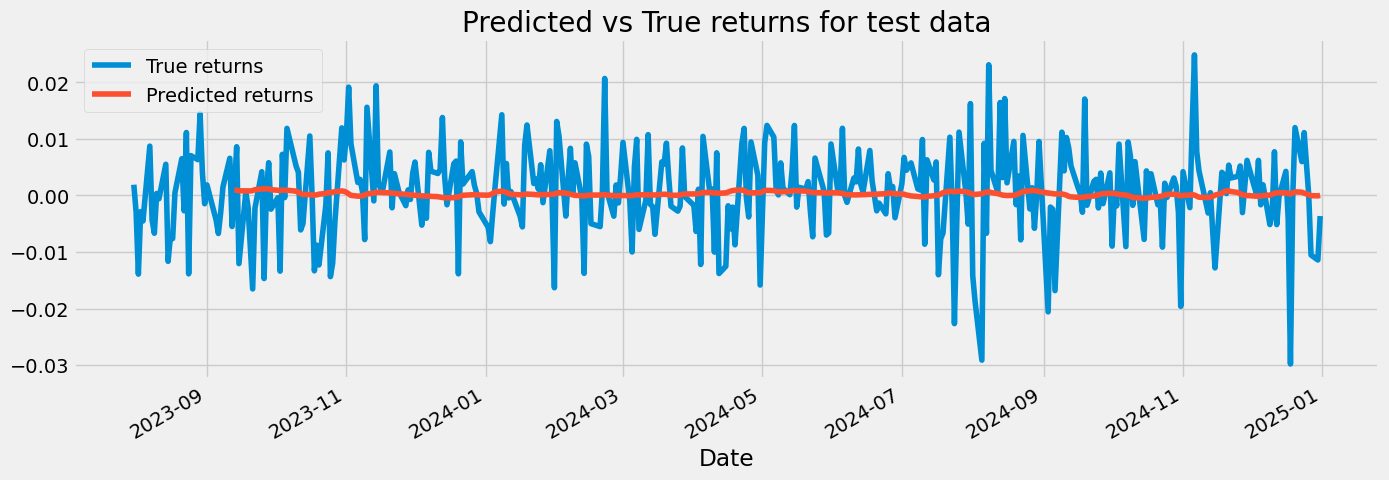

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
df.returns.iloc[index_split:].plot(ax=ax, label='True returns', title='Predicted vs True returns for test data')
df.test_predictions.iloc[index_split:].plot(ax=ax, label='Predicted returns')
ax.legend()
plt.show()

In [54]:
root_mean_squared_error(y_test, test_preds)

0.007917723282259332

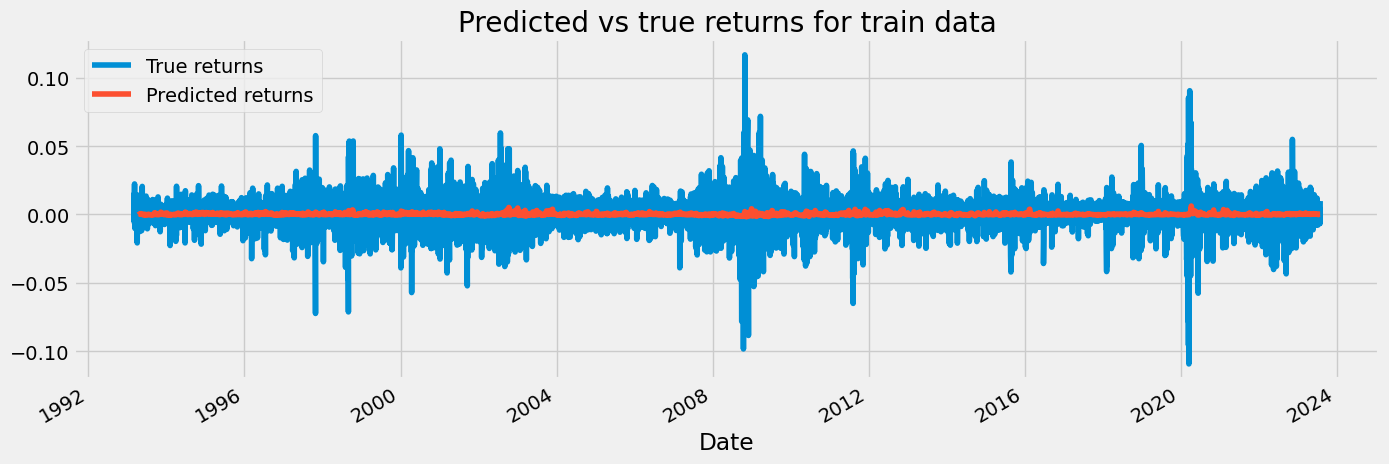

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
df.returns.iloc[:index_split].plot(ax=ax, label='True returns', title='Predicted vs true returns for train data')
df.train_predictions.iloc[:index_split].plot(ax=ax, label='Predicted returns')
ax.legend()
plt.show()

In [58]:
root_mean_squared_error(y_train, train_preds)

0.9998883441735162

# Implement strategy

In [61]:
test = df.iloc[index_split:].copy()

In [93]:
tol = 0.00
test['signal'] = test.test_predictions.apply(lambda x: 1 if x > tol else (-1 if -x > tol else 0))
test['strategy_returns'] = (test.signal * test.returns).cumsum()

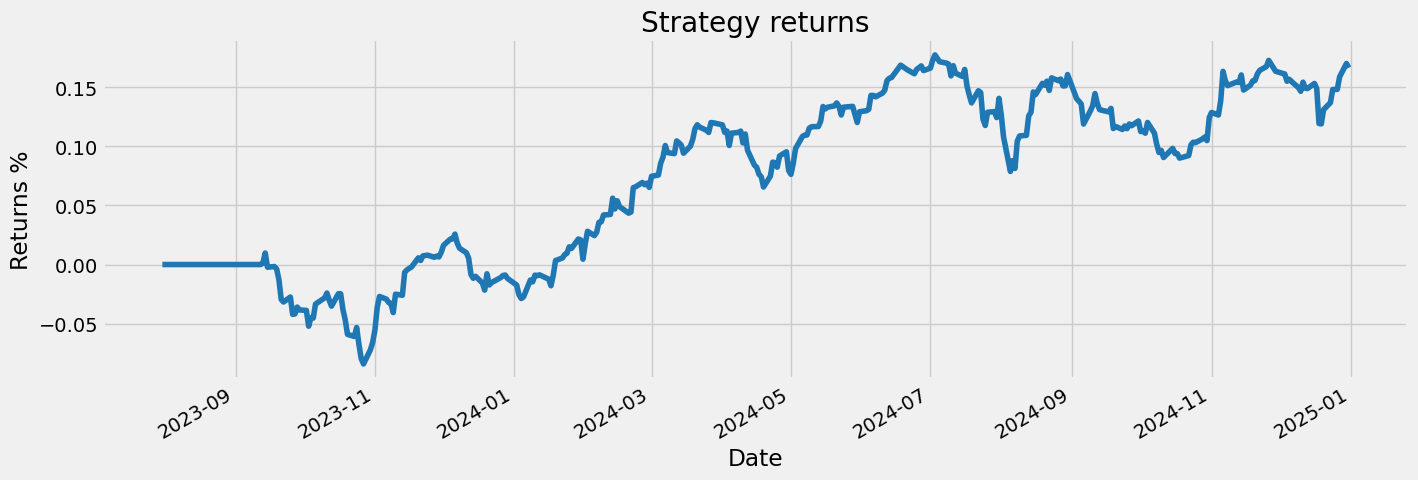

In [95]:
test.strategy_returns.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Strategy returns', 
              ylabel='Returns %')
plt.show()

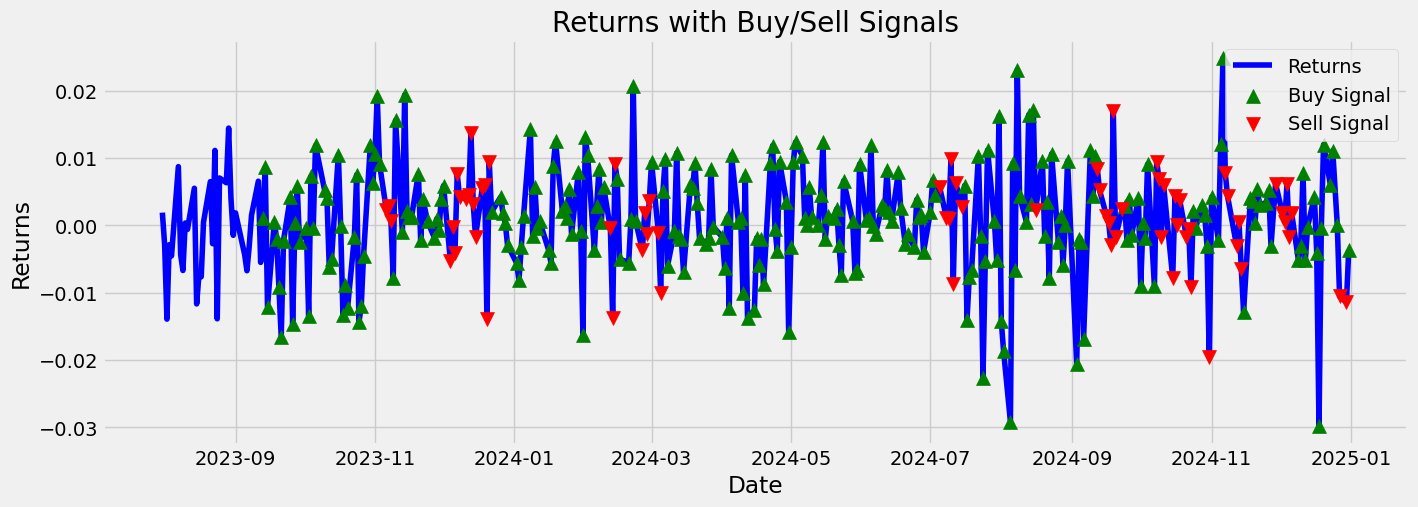

In [97]:
# Create masks for buy and sell signals
buy_mask = test['signal'] == 1
sell_mask = test['signal'] == -1

plt.figure(figsize=(15, 5))

# Plot returns
plt.plot(test.index, test['returns'], label='Returns', color='blue')

# Overlay buy signals
plt.scatter(test.index[buy_mask], test['returns'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)

# Overlay sell signals
plt.scatter(test.index[sell_mask], test['returns'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)

plt.title('Returns with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

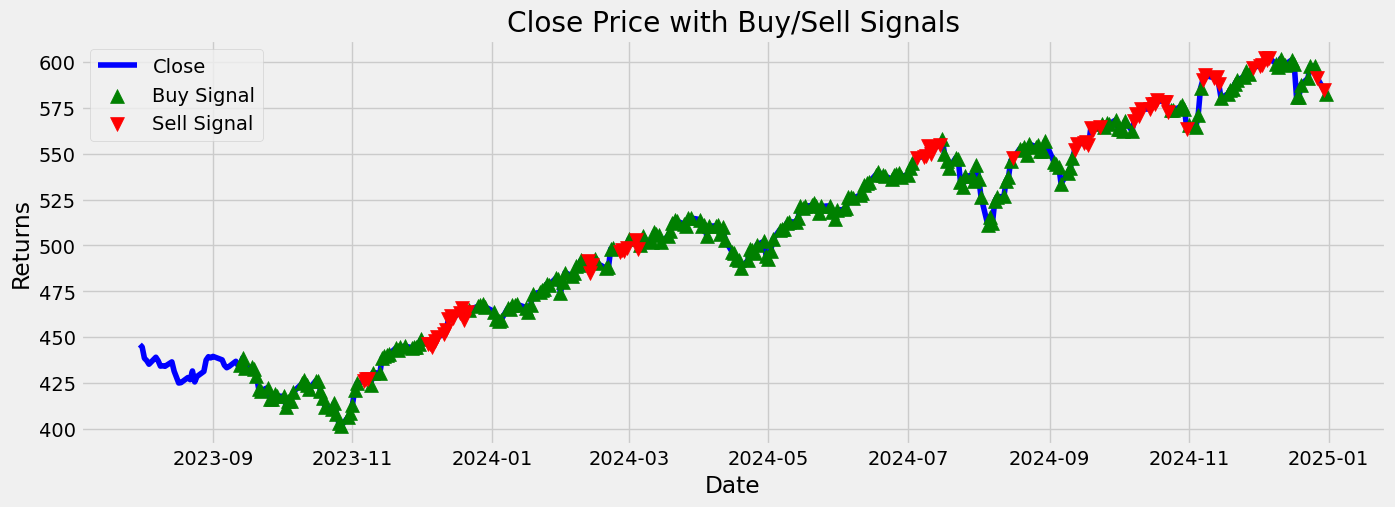

In [99]:
# Create masks for buy and sell signals
buy_mask = test['signal'] == 1
sell_mask = test['signal'] == -1

plt.figure(figsize=(15, 5))

# Plot returns
plt.plot(test.index, test['Close'], label='Close', color='blue')

# Overlay buy signals
plt.scatter(test.index[buy_mask], test['Close'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)

# Overlay sell signals
plt.scatter(test.index[sell_mask], test['Close'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)

plt.title('Close Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [103]:
print(f'Strategy returns: {test.strategy_returns.iloc[-1]*100: .2f}%')
print(f'{ticker} 2024 returns: {100 * (test.Close.iloc[-1] - test.Close.loc['2024-01-02']) / test.Close.loc['2024-01-02']: .2f}%')

Strategy returns:  16.66%
SPY 2024 returns:  25.59%


# Conclusions

Not bad. The predicted vs true returns graphs however indicate that the model struggles predicting the magnitude of daily returns. What appears to be happening is that the model is learning that daily returns are a bit tricky to predict, and that it's best bet of minimising it's loss function is by predicting returns of very close to zero.

What if we block it from doing this by asking it to predict only the direction (and not the magnitude as well).